<a href="https://www.kaggle.com/code/nguyncnghuy/transformer-vi-to-en?scriptVersionId=229743011" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install torchtext==0.16.0 numpy==1.26.4 underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209

In [2]:
import os
import torch

# Configure PyTorch memory allocation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# Clear cache
torch.cuda.empty_cache()

In [3]:
import pandas as pd
import numpy as np
import re,string
from underthesea import word_tokenize
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torch
import torch.nn as nn
from torch.nn import Transformer
from torch.nn.utils.rnn import pad_sequence
from timeit import default_timer as timer
import math
import warnings

import random

## Text Preprocessing

In [4]:
import pandas as pd
train_en_path = "/kaggle/input/iwslt15-englishvietnamese/IWSLT'15 en-vi/train.en.txt"
train_vi_path = "/kaggle/input/iwslt15-englishvietnamese/IWSLT'15 en-vi/train.vi.txt"

with open(train_en_path, 'r', encoding='utf-8') as f:
    train_en_lines = f.read().strip().splitlines()

with open(train_vi_path, 'r', encoding='utf-8') as f:
    train_vi_lines = f.read().strip().splitlines()




# Create a pandas DataFrame and then a Hugging Face Dataset.
data_set = pd.DataFrame({"en": train_en_lines, "vi": train_vi_lines}).iloc[:100000]
print("Number of training examples:", len(data_set))
print("Sample training data:")
print(data_set.head())

Number of training examples: 100000
Sample training data:
                                                  en  \
0  Rachel Pike : The science behind a climate hea...   
1  In 4 minutes , atmospheric chemist Rachel Pike...   
2  I &apos;d like to talk to you today about the ...   
3  Headlines that look like this when they have t...   
4  They are both two branches of the same field o...   

                                                  vi  
0           Khoa học đằng sau một tiêu đề về khí hậu  
1  Trong 4 phút , chuyên gia hoá học khí quyển Ra...  
2  Tôi muốn cho các bạn biết về sự to lớn của nhữ...  
3  Có những dòng trông như thế này khi bàn về biế...  
4  Cả hai đều là một nhánh của cùng một lĩnh vực ...  


In [5]:
def preprocessing(df): 
  df["en"] = df["en"].apply(lambda ele: ele.translate(str.maketrans('', '', string.punctuation))) # Remove punctuation
  df["vi"] = df["vi"].apply(lambda ele: ele.translate(str.maketrans('', '', string.punctuation)))  
  df["en"] = df["en"].apply(lambda ele: ele.lower()) # convert text to lowercase
  df["vi"] = df["vi"].apply(lambda ele: ele.lower())
  df["en"] = df["en"].apply(lambda ele: ele.strip()) 
  df["vi"] = df["vi"].apply(lambda ele: ele.strip()) 
  df["en"] = df["en"].apply(lambda ele: re.sub("\s+", " ", ele)) 
  df["vi"] = df["vi"].apply(lambda ele: re.sub("\s+", " ", ele))
    
  return df

data_set = preprocessing(data_set)
data_set.head()

,en,vi
0,rachel pike the science behind a climate headline,khoa học đằng sau một tiêu đề về khí hậu
1,in 4 minutes atmospheric chemist rachel pike p...,trong 4 phút chuyên gia hoá học khí quyển rach...
2,i aposd like to talk to you today about the sc...,tôi muốn cho các bạn biết về sự to lớn của nhữ...
3,headlines that look like this when they have t...,có những dòng trông như thế này khi bàn về biế...
4,they are both two branches of the same field o...,cả hai đều là một nhánh của cùng một lĩnh vực ...


In [6]:
from sklearn.model_selection import train_test_split
train_df, test_valid_df = train_test_split(data_set, test_size = 0.2, random_state = 42, shuffle = True)
test_df, valid_df = train_test_split(test_valid_df, test_size = 0.5, random_state = 42)
print(f"Train : {len(train_df)}, Valid: {len(valid_df)}, Test: {len(test_df)}, ")

Train : 80000, Valid: 10000, Test: 10000, 


In [7]:
from datasets import Dataset
train_data = Dataset.from_pandas(train_df)
valid_data = Dataset.from_pandas(valid_df)
test_data = Dataset.from_pandas(test_df)
train_data[0]

{'en': 'so you can see delta 1252 going from kansas city to atlanta',
 'vi': 'như các bạn có thể thấy đây là kí hiệu chuyến bay delta 1252 đi từ thành phố kansas tới atlanta',
 '__index_level_0__': 75220}

In [8]:
en_tokenizer = get_tokenizer('basic_english')
def vi_tokenizer(sentence):
    tokens = word_tokenize(sentence)
    return tokens
vi_tokenizer = get_tokenizer(vi_tokenizer)
print(en_tokenizer(train_data[0]["en"]))
print(vi_tokenizer(train_data[0]["vi"]))

['so', 'you', 'can', 'see', 'delta', '1252', 'going', 'from', 'kansas', 'city', 'to', 'atlanta']
['như', 'các', 'bạn', 'có thể', 'thấy', 'đây', 'là', 'kí hiệu', 'chuyến', 'bay', 'delta', '1252', 'đi', 'từ', 'thành phố', 'kansas', 'tới', 'atlanta']


In [9]:
def tokenize_example(example, en_tokenizer, vi_tokenizer, max_length, sos_token, eos_token):
    en_tokens = en_tokenizer(example["en"][:max_length])
    vi_tokens = vi_tokenizer(example["vi"][:max_length])
    en_tokens = [sos_token] + en_tokens + [eos_token]
    vi_tokens = [sos_token] + vi_tokens + [eos_token]
    return {"en_tokens":en_tokens, "vi_tokens":vi_tokens}

In [10]:
sos_token = "<sos>"
eos_token = "<eos>"
max_length = 100
fn_kwargs = {"en_tokenizer" : en_tokenizer, 
             "vi_tokenizer": vi_tokenizer, 
             "max_length":max_length, "sos_token" : sos_token, "eos_token": eos_token}
train_data = train_data.map(tokenize_example, fn_kwargs = fn_kwargs)
valid_data = valid_data.map(tokenize_example, fn_kwargs = fn_kwargs)
test_data = test_data.map(tokenize_example, fn_kwargs = fn_kwargs)

Map:   0%|          | 0/80000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [11]:
min_freq = 3
unk_token = "<unk>"
pad_token = "<pad>"

special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token,
]

en_vocab = build_vocab_from_iterator(
    train_data["en_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

vi_vocab = build_vocab_from_iterator(
    train_data["vi_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)
print(f"English vocab size: {len(en_vocab)}")
print(f"Vietnamese vocab size: {len(vi_vocab)}")

English vocab size: 14754
Vietnamese vocab size: 10963


In [12]:
unk_index = en_vocab["<unk>"]
pad_index = en_vocab["<pad>"]
en_vocab.set_default_index(unk_index)
vi_vocab.set_default_index(pad_index)

In [13]:
def numericalize_example(example, en_vocab, vi_vocab):
    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    vi_ids = vi_vocab.lookup_indices(example["vi_tokens"])
    return {"en_ids":en_ids, "vi_ids":vi_ids}

In [14]:
train_data = train_data.map(numericalize_example, fn_kwargs = {"en_vocab": en_vocab, "vi_vocab": vi_vocab})
test_data = test_data.map(numericalize_example, fn_kwargs = {"en_vocab": en_vocab, "vi_vocab": vi_vocab})
valid_data = valid_data.map(numericalize_example, fn_kwargs = {"en_vocab": en_vocab, "vi_vocab": vi_vocab})

Map:   0%|          | 0/80000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [15]:
vi_vocab.lookup_tokens(train_data[0]["vi_ids"])

['<sos>',
 'như',
 'các',
 'bạn',
 'có thể',
 'thấy',
 'đây',
 'là',
 'kí hiệu',
 'chuyến',
 'bay',
 'delta',
 '<pad>',
 'đi',
 'từ',
 'thành phố',
 'kansas',
 'tới',
 'atlanta',
 '<eos>']

In [16]:
train_data = train_data.with_format(type = "torch", columns = ["en_ids", "vi_ids"])
valid_data = valid_data.with_format(type = "torch", columns = ["en_ids", "vi_ids"])
test_data = test_data.with_format(type = "torch", columns = ["en_ids", "vi_ids"])

In [17]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_en_ids = [example["en_ids"] for example in batch]
        batch_vi_ids = [example["vi_ids"] for example in batch]
        batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index, batch_first = True)
        batch_vi_ids = nn.utils.rnn.pad_sequence(batch_vi_ids, padding_value=pad_index, batch_first = True)
        batch = {
            "en_ids": batch_en_ids,
            "vi_ids": batch_vi_ids,
        }
        return batch

    return collate_fn

In [18]:
from torch.utils.data import DataLoader
batch_size = 32

train_data_loader = DataLoader(train_data, batch_size = batch_size , collate_fn = get_collate_fn(pad_index), shuffle = True)
valid_data_loader = DataLoader(valid_data, batch_size = batch_size , collate_fn = get_collate_fn(pad_index), shuffle = True)
test_data_loader = DataLoader(test_data, batch_size = batch_size , collate_fn = get_collate_fn(pad_index), shuffle = True)

## Encoder layer
- Use positional embedding instead of positional encoding like in the original paper

In [19]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

In [20]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

## Multihead attention

In [21]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
              
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
      
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.reshape(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.reshape(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.reshape(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [22]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

## Decoder layer

In [23]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [24]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

## Tranlation model

In [25]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

In [26]:
INPUT_DIM = len(en_vocab)
OUTPUT_DIM = len(vi_vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [27]:
model = Seq2Seq(enc, dec, pad_index, pad_index, device).to(device)

In [28]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [29]:
model.apply(initialize_weights)

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(14754, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        

In [30]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 13,405,907 trainable parameters


In [31]:
LEARNING_RATE = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

In [32]:
import tqdm
def train_fn(model, iterator, optimizer, criterion, clip, device):
    
    model.train()
    
    epoch_loss = 0
    
    for batch in tqdm.tqdm(iterator):
        
        src = batch["en_ids"].to(device)
        trg = batch["vi_ids"].to(device)
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [33]:
def evaluate_fn(model, iterator, criterion, device):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for batch in tqdm.tqdm(iterator):

            src = batch["en_ids"].to(device)
            trg = batch["vi_ids"].to(device)

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [34]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [35]:
import time
N_EPOCHS = 20
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train_fn(model, train_data_loader, optimizer, criterion, CLIP, device)
    valid_loss = evaluate_fn(model, valid_data_loader, criterion, device)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        model_path = "/kaggle/working/transformer-model.pt"
        torch.save(model.state_dict(), model_path)
        torch.save(model.state_dict(), 'transformer-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

100%|██████████| 313/313 [00:04<00:00, 66.38it/s]


Epoch: 01 | Time: 2m 1s
	Train Loss: 5.079 | Train PPL: 160.564
	 Val. Loss: 4.211 |  Val. PPL:  67.439


100%|██████████| 313/313 [00:04<00:00, 67.22it/s]


Epoch: 02 | Time: 2m 1s
	Train Loss: 3.940 | Train PPL:  51.427
	 Val. Loss: 3.608 |  Val. PPL:  36.900


100%|██████████| 313/313 [00:04<00:00, 67.29it/s]


Epoch: 03 | Time: 2m 1s
	Train Loss: 3.369 | Train PPL:  29.059
	 Val. Loss: 3.296 |  Val. PPL:  27.008


100%|██████████| 313/313 [00:04<00:00, 66.10it/s]


Epoch: 04 | Time: 2m 1s
	Train Loss: 2.992 | Train PPL:  19.930
	 Val. Loss: 3.124 |  Val. PPL:  22.745


100%|██████████| 313/313 [00:04<00:00, 65.01it/s]


Epoch: 05 | Time: 2m 1s
	Train Loss: 2.735 | Train PPL:  15.413
	 Val. Loss: 3.048 |  Val. PPL:  21.066


100%|██████████| 313/313 [00:04<00:00, 67.03it/s]


Epoch: 06 | Time: 2m 1s
	Train Loss: 2.543 | Train PPL:  12.721
	 Val. Loss: 3.017 |  Val. PPL:  20.421


100%|██████████| 313/313 [00:04<00:00, 67.30it/s]


Epoch: 07 | Time: 2m 1s
	Train Loss: 2.390 | Train PPL:  10.912
	 Val. Loss: 3.001 |  Val. PPL:  20.098


100%|██████████| 313/313 [00:04<00:00, 67.48it/s]


Epoch: 08 | Time: 2m 1s
	Train Loss: 2.263 | Train PPL:   9.607
	 Val. Loss: 3.004 |  Val. PPL:  20.156


100%|██████████| 313/313 [00:04<00:00, 67.49it/s]


Epoch: 09 | Time: 2m 1s
	Train Loss: 2.152 | Train PPL:   8.598
	 Val. Loss: 3.025 |  Val. PPL:  20.604


100%|██████████| 313/313 [00:04<00:00, 66.60it/s]


Epoch: 10 | Time: 2m 1s
	Train Loss: 2.054 | Train PPL:   7.799
	 Val. Loss: 3.042 |  Val. PPL:  20.947


100%|██████████| 313/313 [00:04<00:00, 65.44it/s]


Epoch: 11 | Time: 2m 1s
	Train Loss: 1.968 | Train PPL:   7.154
	 Val. Loss: 3.056 |  Val. PPL:  21.244


100%|██████████| 313/313 [00:04<00:00, 63.39it/s]


Epoch: 12 | Time: 2m 2s
	Train Loss: 1.891 | Train PPL:   6.624
	 Val. Loss: 3.095 |  Val. PPL:  22.079


100%|██████████| 313/313 [00:04<00:00, 67.04it/s]


Epoch: 13 | Time: 2m 1s
	Train Loss: 1.824 | Train PPL:   6.196
	 Val. Loss: 3.128 |  Val. PPL:  22.822


100%|██████████| 313/313 [00:04<00:00, 67.76it/s]


Epoch: 14 | Time: 2m 1s
	Train Loss: 1.761 | Train PPL:   5.816
	 Val. Loss: 3.142 |  Val. PPL:  23.155


100%|██████████| 313/313 [00:04<00:00, 68.03it/s]


Epoch: 15 | Time: 2m 1s
	Train Loss: 1.704 | Train PPL:   5.494
	 Val. Loss: 3.207 |  Val. PPL:  24.702


100%|██████████| 313/313 [00:04<00:00, 67.88it/s]


Epoch: 16 | Time: 2m 1s
	Train Loss: 1.652 | Train PPL:   5.217
	 Val. Loss: 3.234 |  Val. PPL:  25.377


100%|██████████| 313/313 [00:04<00:00, 67.03it/s]


Epoch: 17 | Time: 2m 1s
	Train Loss: 1.605 | Train PPL:   4.980
	 Val. Loss: 3.264 |  Val. PPL:  26.165


100%|██████████| 313/313 [00:04<00:00, 67.24it/s]


Epoch: 18 | Time: 2m 1s
	Train Loss: 1.565 | Train PPL:   4.781
	 Val. Loss: 3.308 |  Val. PPL:  27.323


100%|██████████| 313/313 [00:04<00:00, 67.32it/s]


Epoch: 19 | Time: 2m 0s
	Train Loss: 1.526 | Train PPL:   4.601
	 Val. Loss: 3.341 |  Val. PPL:  28.239


100%|██████████| 313/313 [00:04<00:00, 67.49it/s]

Epoch: 20 | Time: 2m 0s
	Train Loss: 1.491 | Train PPL:   4.441
	 Val. Loss: 3.332 |  Val. PPL:  28.005


In [36]:
model.load_state_dict(torch.load('transformer-model.pt'))

test_loss = evaluate_fn(model, test_data_loader, criterion, device)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

100%|██████████| 313/313 [00:05<00:00, 58.90it/s]

| Test Loss: 2.992 | Test PPL:  19.920 |


In [37]:
def translate_sentence(
    sentence,
    model,
    en_tokenizer,
    vi_tokenizer,
    en_vocab,
    vi_vocab,
    lower,
    sos_token,
    eos_token,
    device,
    max_output_length=50,
):
    model.eval()
    with torch.no_grad():
        if isinstance(sentence, str):
            en_tokens = [token for token in en_tokenizer(sentence)]
        else:
            en_tokens = [token for token in sentence]
        if lower:
            en_tokens = [token.lower() for token in en_tokens]
        en_tokens = [sos_token] + en_tokens + [eos_token]
        ids = en_vocab.lookup_indices(en_tokens)
        src_tensor = torch.LongTensor(ids).unsqueeze(0).to(device)
        src_mask = model.make_src_mask(src_tensor)
        with torch.no_grad():
            enc_src = model.encoder(src_tensor, src_mask)
        inputs = en_vocab.lookup_indices([sos_token])
        for i in range(max_output_length):
            inputs_tensor = torch.LongTensor(inputs).unsqueeze(0).to(device)
            inputs_mask = model.make_trg_mask(inputs_tensor)
            with torch.no_grad():
                output, attention = model.decoder(inputs_tensor, enc_src, inputs_mask, src_mask)
            pred_token = output.argmax(2)[:,-1].item()
            inputs.append(pred_token)
            if pred_token == vi_vocab[eos_token]:
                break
        vi_tokens = vi_vocab.lookup_tokens(inputs)
    return vi_tokens, en_tokens, attention

In [38]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [39]:
sentence = "How is the weather today"
lower = True
translation, sentence_tokens, attention = translate_sentence(
    sentence,
    model,
    en_tokenizer,
    vi_tokenizer,
    en_vocab,
    vi_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)

In [40]:
print(f"Translated sentence: {translation}")

Translated sentence: ['<sos>', 'làm', 'thế nào', 'mà', 'thời tiết', 'ngày nay', '<eos>']


In [41]:
sentence_tokens

['<sos>', 'how', 'is', 'the', 'weather', 'today', '<eos>']

## 8 heads , 8 multihead attention

<ipython-input-38-e2b63bd03961>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-38-e2b63bd03961>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


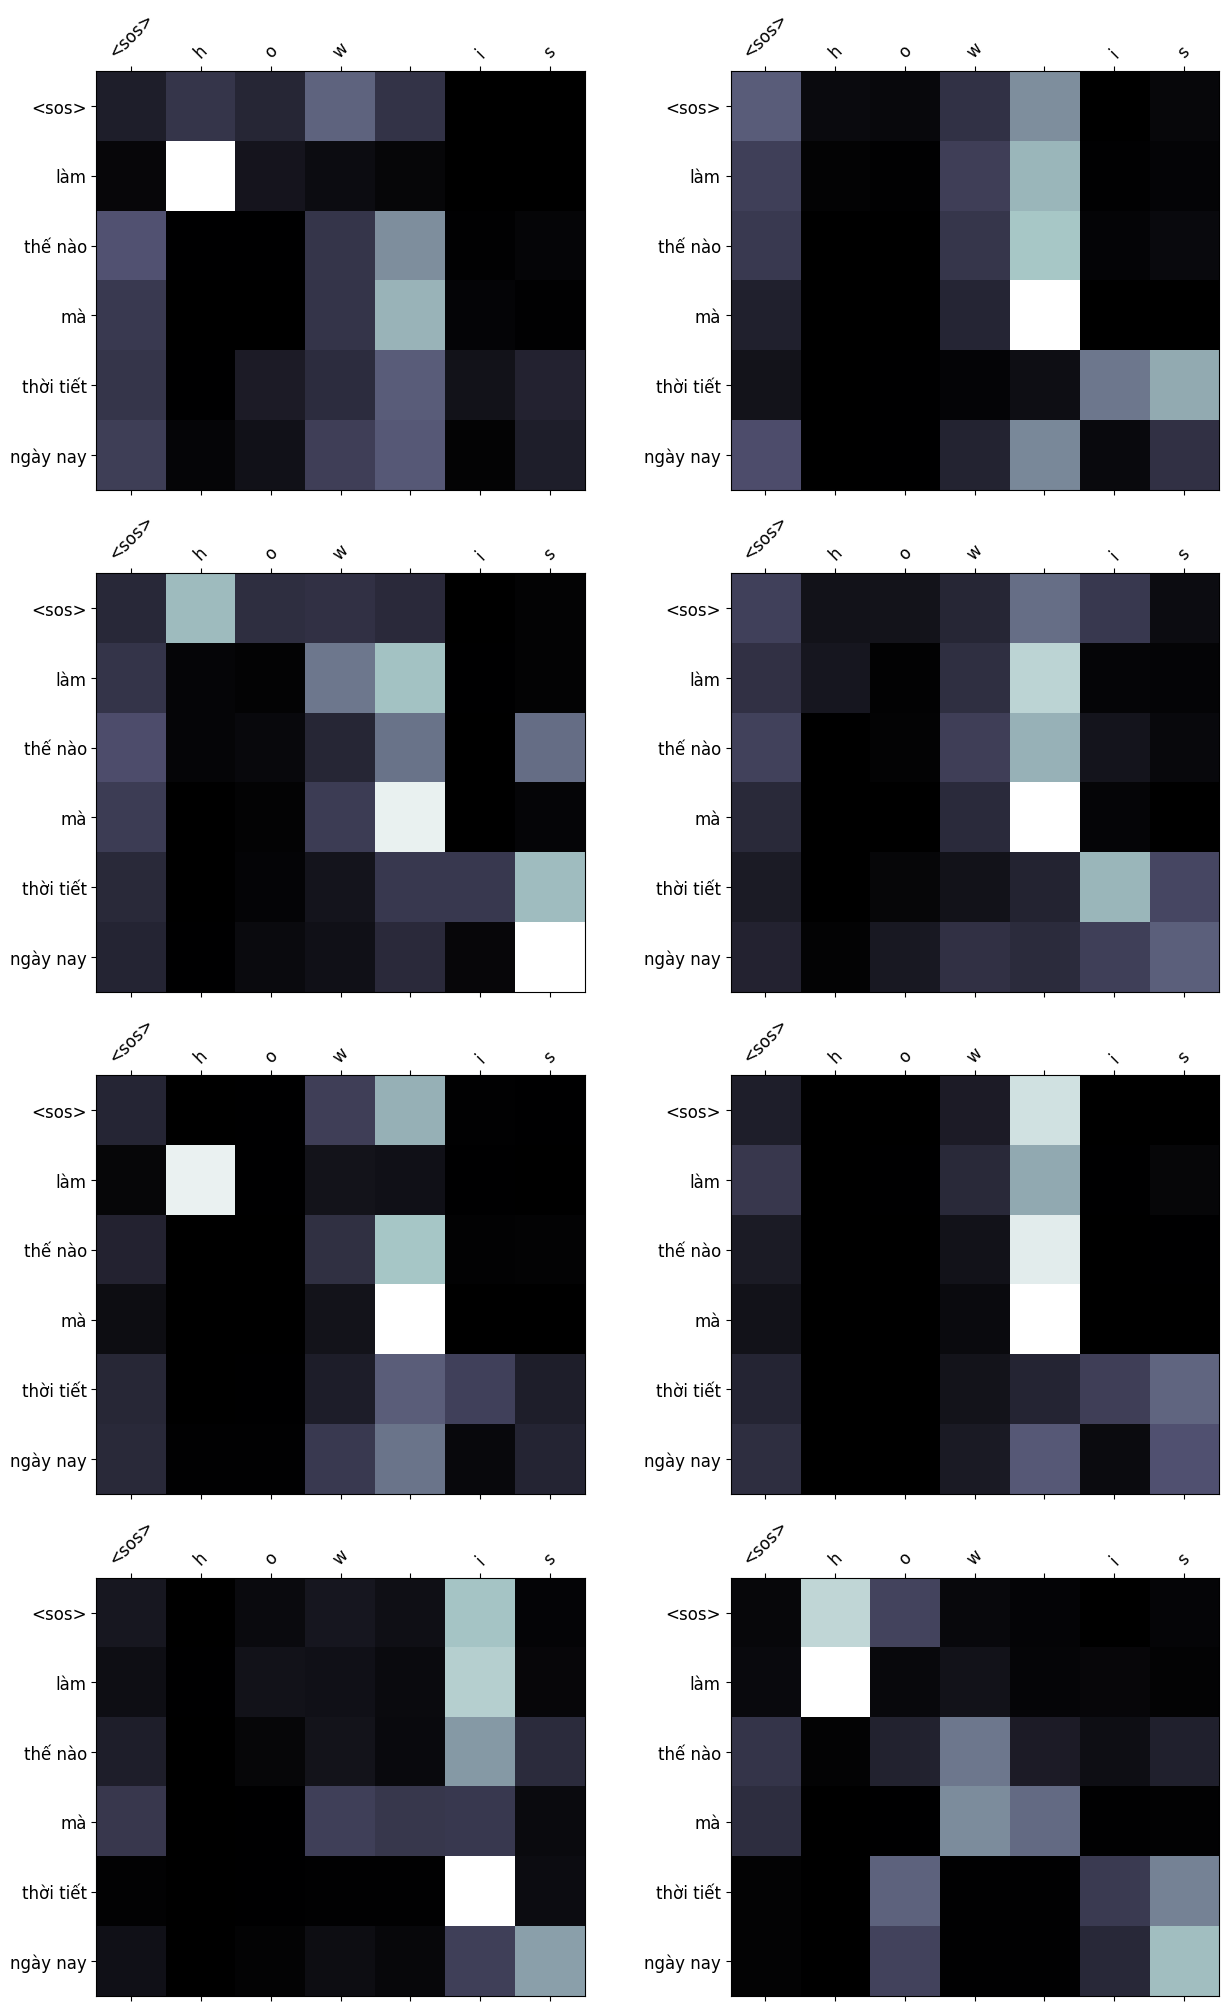

In [42]:
display_attention(sentence, translation, attention)